(interventional_distribution)=
# Conditional vs interventional distributions

:::{post} July, 2023
:tags: causal inference, do-operator
:category: beginner, explanation
:author: Benjamin T. Vincent
:::

:::{attention}
This notebook relies on experimental functionality currently in the [pymc-experimental](https://github.com/pymc-devs/pymc-experimental) repository. In the near future this will be moved into the main [pymc](https://github.com/pymc-devs/pymc) repository.
:::

In this post we are going to learn about the `do` operator. The do-operator is a vital ingredient of doing causal inference, and this notebook will demonstrate what it is, how it works, and how to use it in PyMC.

## Set up the notebook

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
import seaborn as sns

from packaging import version

In [2]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

Check we have the necessary versions to get the new experimental functionality.

In [3]:
assert version.parse(pm.__version__) >= version.parse("5.5.0")
assert version.parse(pmx.__version__) >= version.parse("0.0.7")

# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

## Three different causal DAGS

:::{note}
This section take inspiration from the post [Causal Inference 2: Illustrating Interventions via a Toy Example](https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/) by Ferenc Huszár.
:::

If we think about how variables $x$ and $y$ are related, we can come up with many different causal DAGS. Below we consider just 3 possibilities, which we'll label Script 1, 2, and 3.

1. $x$ causally influences $y$
2. $y$ causally influences $x$
3. $z$ causally influences both $x$ and $y$

We can draw these more graphically below:

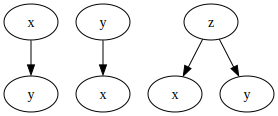

In [4]:
g = gr.Digraph()

# script 1
g.node(name="x1", label="x")
g.node(name="y1", label="y")
g.edge(tail_name="x1", head_name="y1")

# script 2
g.node(name="y2", label="y")
g.node(name="x2", label="x")
g.edge(tail_name="y2", head_name="x2")

# script 3
g.node(name="z", label="z")
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="z", head_name="x")
g.edge(tail_name="z", head_name="y")

g

We can also imagine implementing such causal DAGS in Python code to generate `N` random numbers. Each of these will give rise to specific joint distributions, $P(x, y)$, and in fact, because Ferenc Huszár was clever in his blog post, we'll see later that these will all give rise to the same joint distributions.

**Script 1**

```{code-block} python
x = rng.normal(loc=0, scale=1, size=N)
y = x + 1 + np.sqrt(3) * rng.normal(size=N)
```

**Script 2**

```{code-block} python
y = 1 + 2 * rng.normal(size=N)
x = (y - 1) / 4 + np.sqrt(3) * rng.normal(size=N) / 2
```

**Script 3**

```{code-block} python
z = rng.normal(size=N)
y = z + 1 + np.sqrt(3) * rng.normal(size=N)
x = z
```

However, we are going to implement these using Bayesian causal DAGS with PyMC. Let's see how we can do this, then generate samples from them using `pm.sample_prior_predictive`. As we go with each script, we'll package the data up in `DataFrame`'s for plotting later, and also plot the graphviz representation of the PyMC models. You'll see that while these are a fraction more visually complex, they do actually match up with the causal DAGs we've specified above.

In [5]:
# number of samples to generate
N = 1_000_000

Sampling: [temp, x]


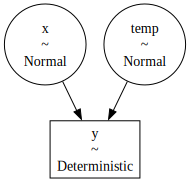

In [6]:
with pm.Model() as model1:
    x = pm.Normal("x")
    temp = pm.Normal("temp")
    y = pm.Deterministic("y", x + 1 + np.sqrt(3) * temp)
    idata1 = pm.sample_prior_predictive(samples=N)

df1 = az.extract(idata1.prior, var_names=["x", "y"]).to_dataframe()

pm.model_to_graphviz(model1)

Sampling: [temp, y]


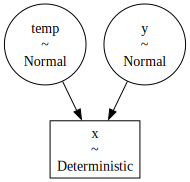

In [7]:
with pm.Model() as model2:
    y = pm.Normal("y", mu=1, sigma=2)
    temp = pm.Normal("temp")
    x = pm.Deterministic("x", (y - 1) / 4 + np.sqrt(3) * temp / 2)
    idata2 = pm.sample_prior_predictive(samples=N)

df2 = az.extract(idata2.prior, var_names=["x", "y"]).to_dataframe()

pm.model_to_graphviz(model2)

Sampling: [temp, z]


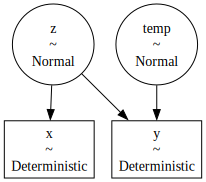

In [8]:
with pm.Model() as model3:
    z = pm.Normal("z")
    temp = pm.Normal("temp")
    y = pm.Deterministic("y", z + 1 + np.sqrt(3) * temp)
    x = pm.Deterministic("x", z)
    idata3 = pm.sample_prior_predictive(samples=N)

df3 = az.extract(idata3.prior, var_names=["x", "y"]).to_dataframe()

pm.model_to_graphviz(model3)

### Joint distributions, $P(x,y)$

First, let's take a look at the joint distributions for each of the scripts to convince ourselves that these are actually the same.

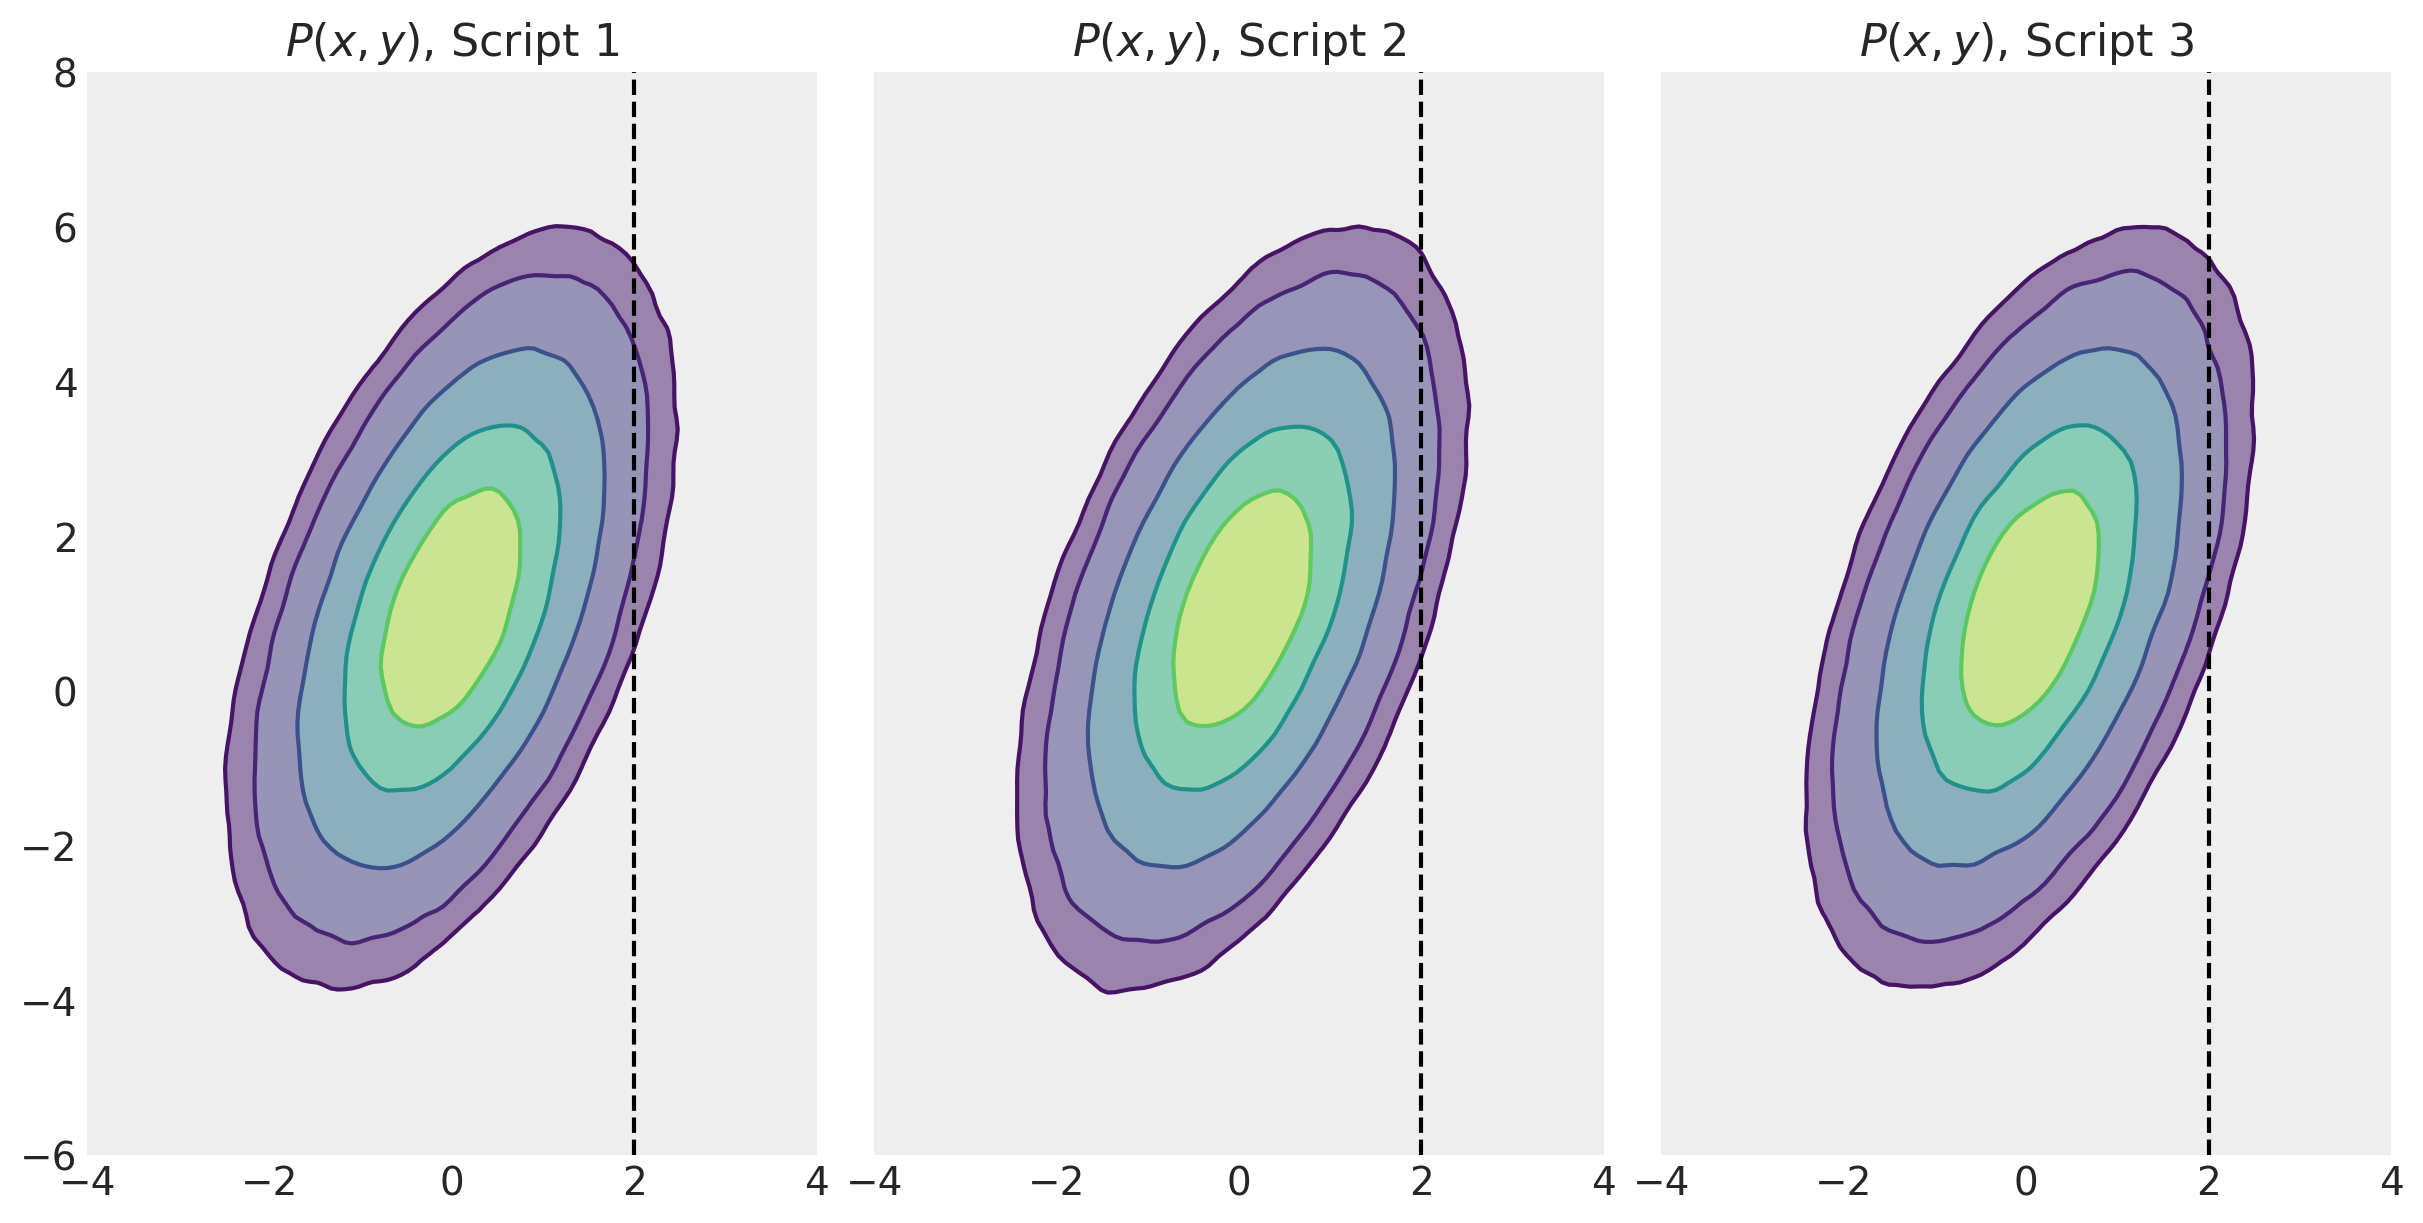

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)

for i, df in enumerate([df1, df2, df3]):
    az.plot_kde(
        df["x"],
        df["y"],
        hdi_probs=[0.25, 0.5, 0.75, 0.9, 0.95],
        contour_kwargs={"colors": None},
        contourf_kwargs={"alpha": 0.5},
        ax=ax[i],
    )
    ax[i].set(
        title=f"$P(x, y)$, Script {i+1}",
        xlim=[-4, 4],
        xticks=np.arange(-4, 4 + 1, step=2),
        ylim=[-6, 8],
        yticks=np.arange(-6, 8 + 1, step=2),
    )
    ax[i].axvline(x=2, ls="--", c="k")

The dashed lines at $x=2$ help us imagine the conditional distribution $P(y|x=2)$ that we'll examine in the next section. Seeing as the joint distributions are the same, it is intuitive to imagine that the conditional distributions $P(y|x=2)$ will be identical for each of the 3 scripts.

### Conditional distributions, $P(y|x=2)$

In the MCMC spirit of representing probability distributions by samples, let's now calculate the conditional distributions. If we picked all the values where $x$ was _exactly_ 2, then we might not end up with any samples at all, so what we'll do is to take a very narrow slice of samples around 2. So these will be approximations - as the number of samples increases and the width of the slice decreases, then our approximation would become more accurate.

In [10]:
# Extract samples from P(y|x=2)
conditional1 = df1.query("1.99 < x < 2.01")["y"]
conditional2 = df2.query("1.99 < x < 2.01")["y"]
conditional3 = df3.query("1.99 < x < 2.01")["y"]

In [11]:
# put the conditional distributions into a convenient long-format data frame
df1_new = pd.DataFrame({"Conditional": conditional1, "Script": "Script 1"})
df2_new = pd.DataFrame({"Conditional": conditional2, "Script": "Script 2"})
df3_new = pd.DataFrame({"Conditional": conditional3, "Script": "Script 3"})
df_conditional = pd.concat([df1_new, df2_new, df3_new])
df_conditional.reset_index(drop=True, inplace=True)

### Interventional distributions, $P(y|do(x=2))$

In turn for each of the 3 scripts, let's use the `do` operator, setting $x=2$. This will give us a new DAG and we'll plot the graphviz representation and then take samples to represent the interventional distribution.

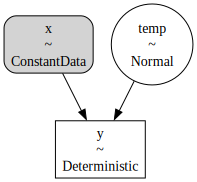

In [12]:
model1_do = do(model1, {"x": 2})
pm.model_to_graphviz(model1_do)

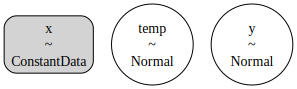

In [13]:
model2_do = do(model2, {"x": 2})
pm.model_to_graphviz(model2_do)

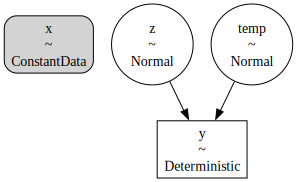

In [14]:
model3_do = do(model3, {"x": 2})
pm.model_to_graphviz(model3_do)

So we can see that in script 1, the $x$ variable still has causal influence on $y$. However, in scripts 2 and 3, $y$ is no longer causally influenced by $x$. So in scripts 2 and 3, our intervention $do(x=2)$ have no influence on $y$.

Next we'll sample from each of these interventional distributions. Note that we are using the mutilated models, `model1_do`, `model2_do`, and `model3_do`. 

In [15]:
with model1_do:
    idata1_do = pm.sample_prior_predictive(samples=N)

with model2_do:
    idata2_do = pm.sample_prior_predictive(samples=N)

with model3_do:
    idata3_do = pm.sample_prior_predictive(samples=N)

Sampling: [temp]
Sampling: [temp, y]
Sampling: [temp, z]


In [16]:
# put the interventional distributions into a convenient long-format data frame
df1_new = pd.DataFrame(
    {
        "Interventional": az.extract(idata1_do.prior, var_names="y").squeeze().data,
        "Script": "Script 1",
    }
)
df2_new = pd.DataFrame(
    {
        "Interventional": az.extract(idata2_do.prior, var_names="y").squeeze().data,
        "Script": "Script 2",
    }
)
df3_new = pd.DataFrame(
    {
        "Interventional": az.extract(idata3_do.prior, var_names="y").squeeze().data,
        "Script": "Script 3",
    }
)
df_interventional = pd.concat([df1_new, df2_new, df3_new])
df_interventional.reset_index(drop=True, inplace=True)

So let's compare the conditional and interventional distributions for all 3 scripts.

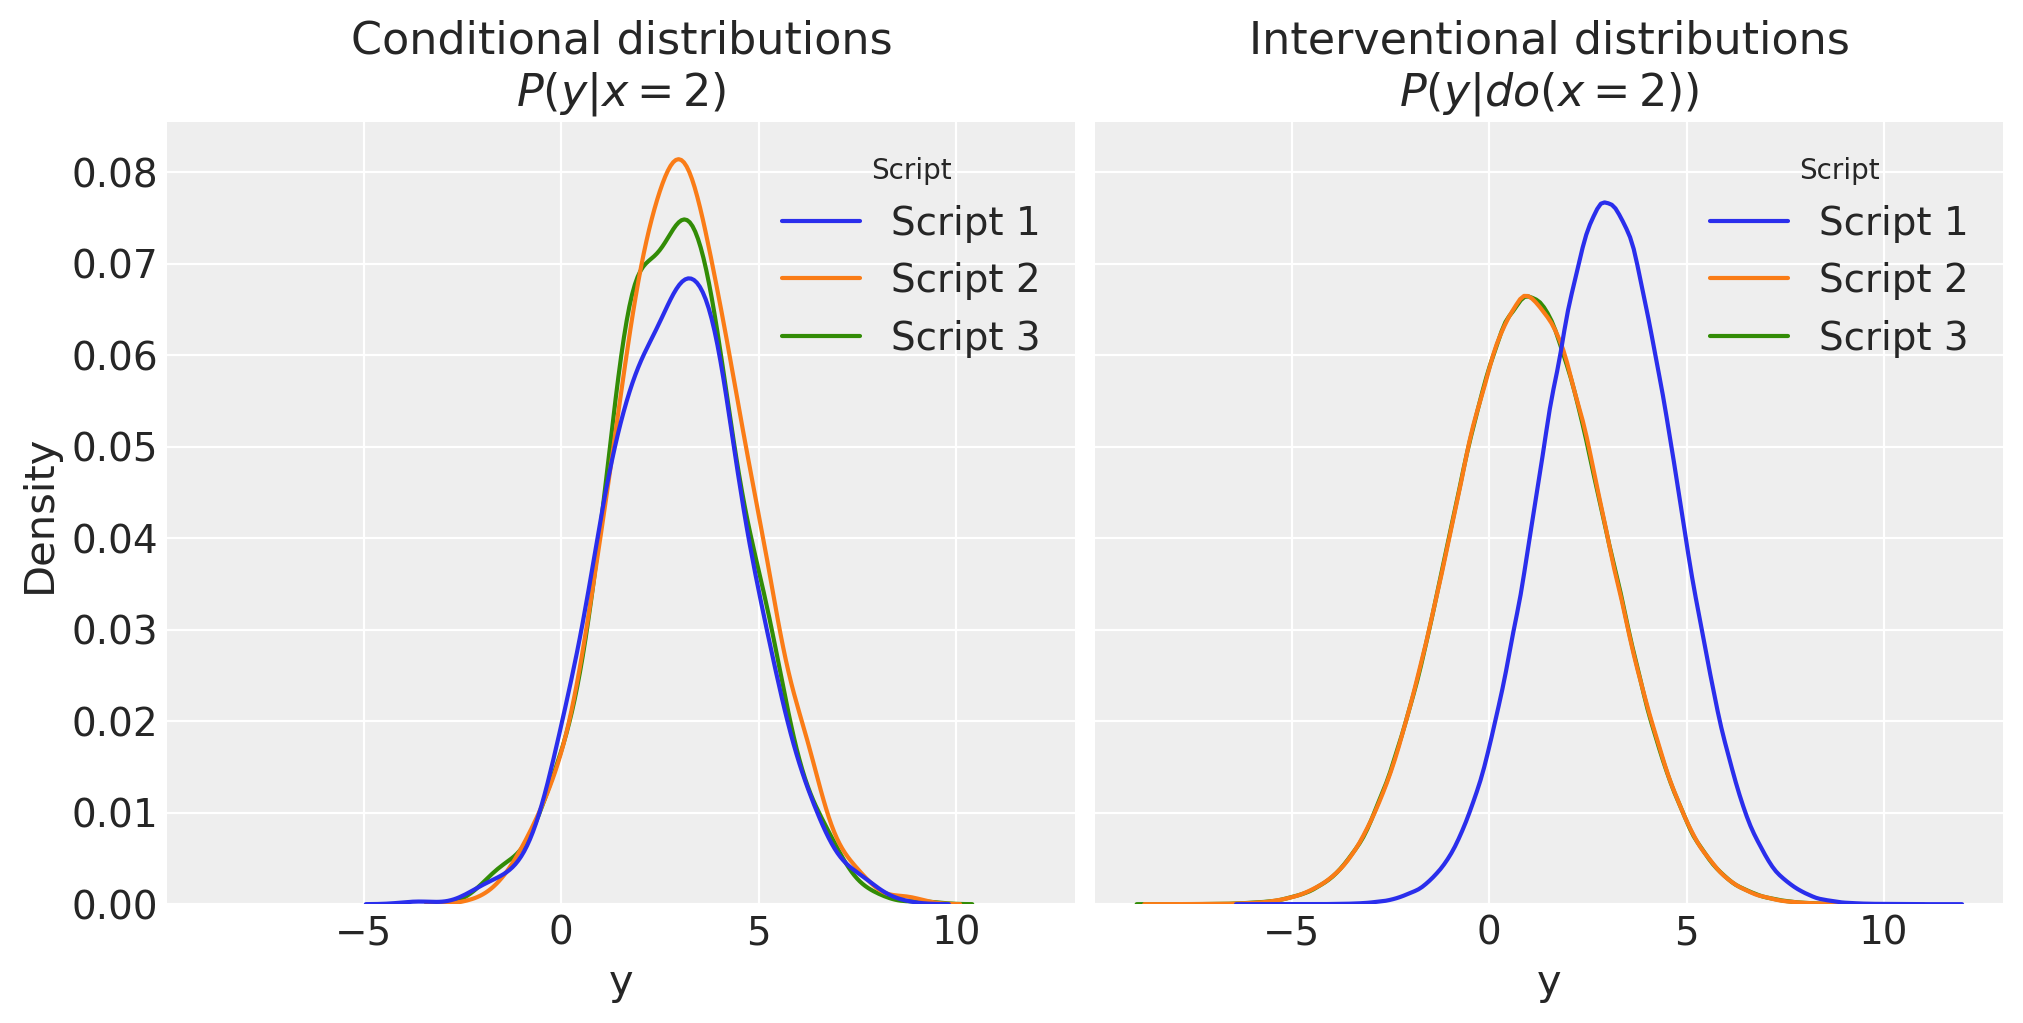

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.kdeplot(df_conditional, x="Conditional", hue="Script", common_norm=True, ax=ax[0])
ax[0].set(xlabel="y", title="Conditional distributions\n$P(y|x=2)$")

sns.kdeplot(df_interventional, x="Interventional", hue="Script", common_norm=True, ax=ax[1])
ax[1].set(xlabel="y", title="Interventional distributions\n$P(y|do(x=2))$");

We can see, as expected, that the conditional distributions are the same for all 3 scripts. The story is different for the interventional distributions however. Here, script 1 differs because it is the only one where our $do(x=2)$ intervention causally effects $y$. This intervention severed any causal influence of $x$ on $y$ in scripts 2 and 3.

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2023

## Watermark

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sun Jul 02 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.12.3
xarray  : 2023.6.0

pandas           : 2.0.3
seaborn          : 0.12.2
pymc             : 5.5.0
matplotlib       : 3.7.1
packaging        : 23.1
numpy            : 1.25.0
arviz            : 0.15.1
graphviz         : 0.20.1
pymc_experimental: 0.0.7

Watermark: 2.3.1



:::{include} ../page_footer.md
:::